To do:
- singnal estension
- weekly psf
- same analysis from wavelet filter

In [ ]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.signal import deconvolve
from sklearn.metrics import mean_squared_error as mse
from analysis import *

In [2]:
data = pd.read_csv("Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)

Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0

Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric = Electric[['Date', 'Seconds', 'Load']]
Electric['Day'] = Electric['Date'].dt.day_name()
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour
Electric.columns

Index(['Date', 'Seconds', 'Load', 'Day', 'Minutes', 'Hour'], dtype='object')

In [5]:
# Week
signal_reconstr = fourierExtrapolation(Electric.Load.values, int(96*7), n_harm=10)

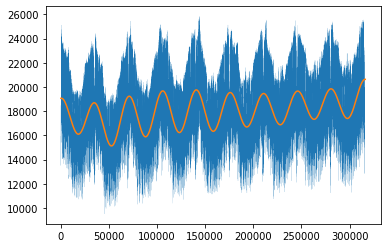

In [7]:
plt.plot(Electric.Load.values, lw=0.1)
plt.plot(signal_reconstr)

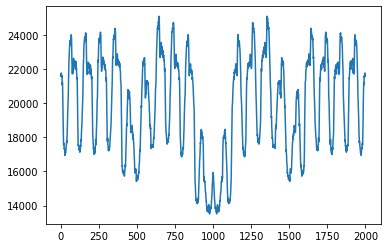

In [8]:
plt.plot(np.concatenate([Electric.Load.values[:1000][::-1], Electric.Load.values[:1000]]))
#plt.xlim(900,1000)

In [ ]:
# prima di fare le analisi simili a quelle di gioacchino bisogna estendere 
# il segnale in modo tale da eliminare gli effetti sui bordi dati dalla
# convoluzione.

In [9]:
psf = Electric.groupby(['Hour', 'Minutes']).mean().reset_index()['Load'].to_numpy()
psf /= psf.sum()

f = {'Load': ['mean', q1, q2]}

psfs = Electric.groupby(['Hour', 'Minutes']).agg(f).reset_index()['Load'].to_numpy()

psf = psfs[:, 0]
psf_q1 = psfs[:, 1]
psf_q2 = psfs[:, 2]

In [10]:
load = Electric.Load.values

def deconvolution(signal, psf, window=96):
    deconv = np.zeros(len(signal))
    for i in range(len(signal) // window):
        deconv[i*window:(i+1)*window +1] = deconvolve(signal[(i*window) : (i+2)*window], psf)[0]
        deconv[(i+1)*window:(i+2)*window+1] = deconvolve(signal[(i+1)*window:(i+3)*window], psf)[0]
    return deconv

deconv_psf = deconvolution(load, psf)
deconv_psfq1 = deconvolution(load, psf_q1)
deconv_psfq2 = deconvolution(load, psf_q2)

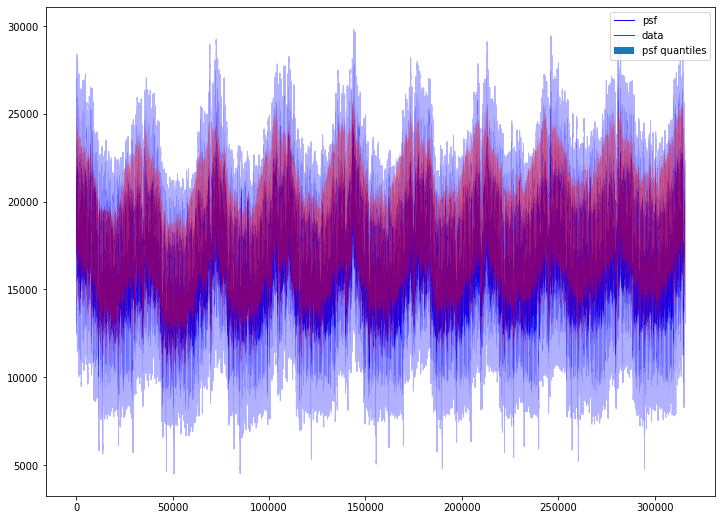

In [30]:
load_psf = np.convolve(deconv_psf, psf, 'valid')[:-96]
load_q1 = np.convolve(deconv_psfq1, psf_q1, 'valid')[:-96]
load_q2 = np.convolve(deconv_psfq2, psf_q2, 'valid')[:-96]
t = range(len(load_psf))

plt.figure(figsize=(12, 9))
plt.plot(load_psf, 'b', lw=0.1, label='psf')
plt.fill_between(x=t, y1=load_q1, y2=load_q2, color='b', alpha=0.3,
                 label='psf quantiles')
plt.plot(load, 'r', lw=0.1, alpha=0.5, label='data')
leg = plt.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(1)